In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import ordpy

%matplotlib inline

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))


from tslearn.metrics import dtw as Dtw
# from dtaidistance import dtw
import itertools 

# Functions' definitions

In [7]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [8]:
#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

# Disks

<p style="font-size=200px;"><b>Classification:</b></p>

1) ???

2) ???

3) Steady or periodic behavior</p>

In [9]:
disk_human_class = scipy.io.loadmat('classification/humanClassificationCircle.mat')['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/dataCircleClassified.mat')

In [164]:
# for i, j, k in zip(mat2['dx'], mat2['dy'], range(len(mat2['dy']))):
#     if k in np.argwhere(mat2['behaviourAuto'][0]==3).flatten():
#         print('\n', i, j, k, "###############################", '\n')
#     else:
#         print('not steady', i, j)

In [54]:
#Improving data structure. Extracting data from dataCircle.mat and loading it into data arrays
disk_data = scipy.io.loadmat('classification/dataCircle.mat')

#initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
disk_initcons = []
for i in range(len(disk_data['data'][0])):
    disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
disk_initcons = np.asarray(disk_initcons)

# radii of the disks dropped
disk_radii = []
for i in range(len(disk_data['data'][0])):
    disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
disk_radii = np.asarray(disk_radii)

# camera 1 observable area?
disk_cam1 = []
for i in range(len(disk_data['data'][0])):
    disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0])
disk_cam1 = np.asarray(disk_cam1)

# camera 2 observable area?
disk_cam2 = []
for i in range(len(disk_data['data'][0])):
    disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0])
disk_cam2 = np.asarray(disk_cam2)

# coordinates (x, y, z) along trajectory from 1m high to the floor.
disk_trajectories = []
for i in range(len(disk_data['data'][0])):
    disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
disk_trajectories = np.asarray(disk_trajectories)

## data cleaning

In [127]:
clean_disk_trajectories = []
clean_disk_initcons     = []
clean_disk_class        = []
clean_disk_radii        = []
clean_disk_cam2         = []
clean_disk_cam1         = []

for i in range(len(disk_trajectories)):
    #vertical trajectory
    z                = disk_trajectories[i][::,2]
    # removing the last 5 centimeters of the fall.
    trajectory       = disk_trajectories[i][z>.05]

#(original comment) Segment steady and periodic behaviours from trajectories. 
#We only see steady and periodic from horizontal initial condition.
    if disk_initcons[i]==0:        
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<.2*disk_radii[i]
        steady_index       = boolean_trajectory.tolist().index(False)

        if steady_index>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
            clean_disk_trajectories.append(trajectory[:steady_index])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(3)
            
            if len(trajectory[steady_index:])>10: #second part of the sliced original trajectory.
                clean_disk_trajectories.append(trajectory[steady_index:])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                
            else: pass
        
        else: #no segmentation; only one behavior through the whole fall
            clean_disk_trajectories.append(trajectory[steady_index:])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
                
    else: #no trajectory segmentation
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<0.01
        cut_index          = boolean_trajectory.tolist().index(False)
        
        if len(trajectory[cut_index:])>10: #second part of the sliced original trajectory.
            clean_disk_trajectories.append(trajectory[cut_index:])
            clean_disk_initcons.append(1)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)

np.save('pickles/clean_disk_trajectories.npy', clean_disk_trajectories)
np.save('pickles/clean_disk_initcons.npy', clean_disk_initcons)    
np.save('pickles/clean_disk_class.npy', clean_disk_class)       
np.save('pickles/clean_disk_radii.npy', clean_disk_radii)       
np.save('pickles/clean_disk_class.npy', clean_disk_class)       

Text(0.5, 0, 'x, lateral')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


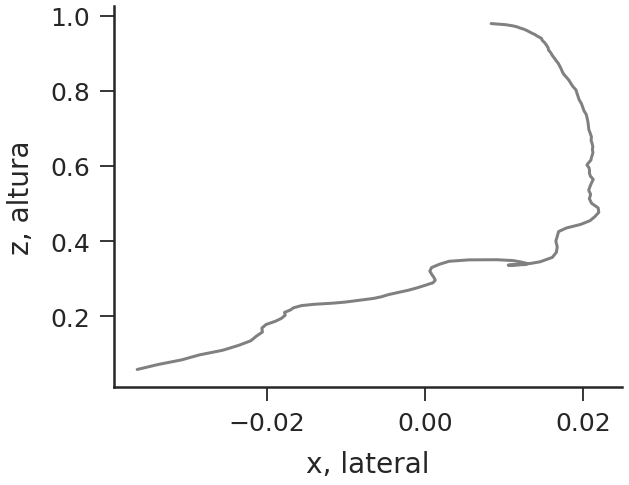

In [129]:
f, ax = plt.subplots()

i      = 21
x_, y_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]

ax.plot(x_, y_, '-', color='grey')
ax.set_ylabel('z, altura')
ax.set_xlabel('x, lateral')

In [184]:
disk_ce = []
for i, class_ in zip(range(len(clean_disk_trajectories)), clean_disk_class):
    if not class_==3:
        ts = clean_disk_trajectories[i][::,2]
        disk_ce.append(ordpy.complexity_entropy(ts, dx=4))
    else:
        pass

In [180]:
disk_human_class.__len__()

218

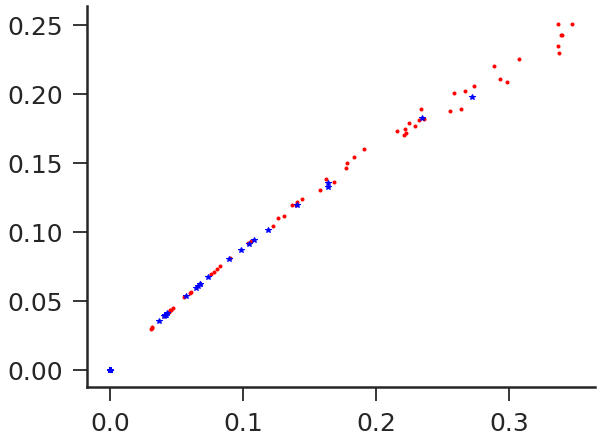

In [185]:
a = disk_human_class
a = a[a!=3]

for (h_, c_), class_ in zip(disk_ce, a):
    if class_==1:
        plt.plot(h_,c_, '.', marker='*', color='blue')
    else:
        plt.plot(h_,c_, '.', color='red', zorder=0)

In [69]:
# 21seconds to run.
dtw_matrix = []
A = range(disk_trajectory.__len__())

for i,j in list(itertools.product(A, A)):
    ts1 = disk_trajectory[i]
    ts2 = disk_trajectory[j]
    dtw_matrix.append(Dtw(ts1, ts2))

In [79]:
from scipy.cluster.hierarchy import average as ClusAvg
from scipy.spatial.distance import pdist as Pdist
from scipy.cluster.hierarchy import fcluster as Fcluster

In [71]:
dtw_matrix_shape = np.reshape(dtw_matrix, (170,-1))

In [76]:
y = Pdist(dtw_matrix_shape)

In [85]:
Z = ClusAvg(y)

In [86]:
Z

array([[ 58.        , 135.        ,   0.98516109,   2.        ],
       [  5.        ,  85.        ,   1.17740812,   2.        ],
       [ 22.        , 138.        ,   1.2516876 ,   2.        ],
       [ 36.        ,  95.        ,   1.46373152,   2.        ],
       [ 27.        ,  68.        ,   1.48460509,   2.        ],
       [ 26.        , 127.        ,   1.49605171,   2.        ],
       [ 19.        ,  83.        ,   1.64174705,   2.        ],
       [ 76.        , 120.        ,   1.68810495,   2.        ],
       [ 49.        , 144.        ,   1.69288316,   2.        ],
       [ 65.        , 165.        ,   1.77420147,   2.        ],
       [ 82.        , 171.        ,   1.80293752,   3.        ],
       [106.        , 131.        ,   1.80519182,   2.        ],
       [ 71.        ,  88.        ,   1.90544641,   2.        ],
       [ 74.        , 133.        ,   1.93795326,   2.        ],
       [ 59.        ,  75.        ,   1.94042893,   2.        ],
       [ 69.        , 180

In [84]:
Fcluster(Z, t=40, criterion='distance')

array([1, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       1, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 1, 2,
       2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3,
       1, 1, 3, 3, 2, 3, 3, 2, 2, 3, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 3], dtype=int32)

Falta dar um jeito de ler o código do cara e entender o critério dele pra separar um trajetória em duas, no caso, em uma parcela de
trajetória estacionária (periódica) e outro tipo (caótica ou "tumbling").

In [150]:
mat = scipy.io.loadmat('classification/Field1997_data.mat')

In [165]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun 12 09:44:01 2019',
 '__version__': '1.0',
 '__globals__': [],
 'c': array([[2.38277644e+01, 3.89184311e-03, 1.00000000e+00],
        [3.36187395e+01, 3.89184311e-03, 1.00000000e+00],
        [2.40504822e+01, 4.83471860e-03, 1.00000000e+00],
        [3.62164057e+01, 4.83471860e-03, 1.00000000e+00],
        [3.65549199e+01, 5.12939850e-03, 1.00000000e+00],
        [4.12545834e+01, 5.38863962e-03, 1.00000000e+00],
        [4.69936378e+01, 5.23156373e-03, 1.00000000e+00],
        [7.20944119e+01, 3.89184311e-03, 1.00000000e+00],
        [6.63036129e+01, 4.60212597e-03, 1.00000000e+00],
        [7.20944119e+01, 4.97987935e-03, 1.00000000e+00],
        [7.34484412e+01, 5.49596830e-03, 1.00000000e+00],
        [5.92995386e+01, 5.44203937e-03, 1.00000000e+00],
        [6.88175415e+01, 5.33576384e-03, 1.00000000e+00],
        [2.71425194e+01, 6.56341608e-03, 1.00000000e+00],
        [4.08725483e+01, 6.62845751e-03, 1.00

# Hexagons

# Squares

# Crosses